## Ungraded Lab: Training with ImageDataGenerator

in this lab we will build and train a model on the **Horses and Humans** dataset. We will use the **ImageDataGenerator** class to prepare this dataset so it can be fed into a Conv. NN

Run the code below to download the compressed dataset 

In [21]:
import urllib.request
import os 
url = "https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip"


We can then unzip the archive uing the zipfile module

The contents of the .zip are extracted to the base directory ./horese-or-human which in turn contain _horses_ and _humans_ subdirectories

Notice: We don't explicitly label the images as horses or humans. We will use the ImageDataGenerator API instead - and this is coded to automatically label images according to the directory names and structure. For example we will have a _training_ directory containing a _horses_ directory and a _humans_ one. ImageDataGenerator will label the images appropriately, reducing a coding step.

We can now define each of these directories:

In [24]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('./horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('./horse-or-human/humans')

Now see what the filenames look like in the _horses_ and _humans_ training directories

In [27]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

['horse01-0.png', 'horse01-1.png', 'horse01-2.png', 'horse01-3.png', 'horse01-4.png', 'horse01-5.png', 'horse01-6.png', 'horse01-7.png', 'horse01-8.png', 'horse01-9.png']
['human01-00.png', 'human01-01.png', 'human01-02.png', 'human01-03.png', 'human01-04.png', 'human01-05.png', 'human01-06.png', 'human01-07.png', 'human01-08.png', 'human01-09.png']


We can also find out the total number of horse and human images in the directories

In [29]:
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

total training horse images: 500
total training human images: 527


Now we can take a look at a few pictures to get a better sense of what they look like. First, we configure the _matplotlib_ parameters:

In [32]:
%matplotlib inline 

import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows=4
ncols=4 

# Index for iterating over images
pic_index = 0

Now we can display a batch of 8 horse and 8 human pictures. We can rerun the cell to see a fresh batch each time:

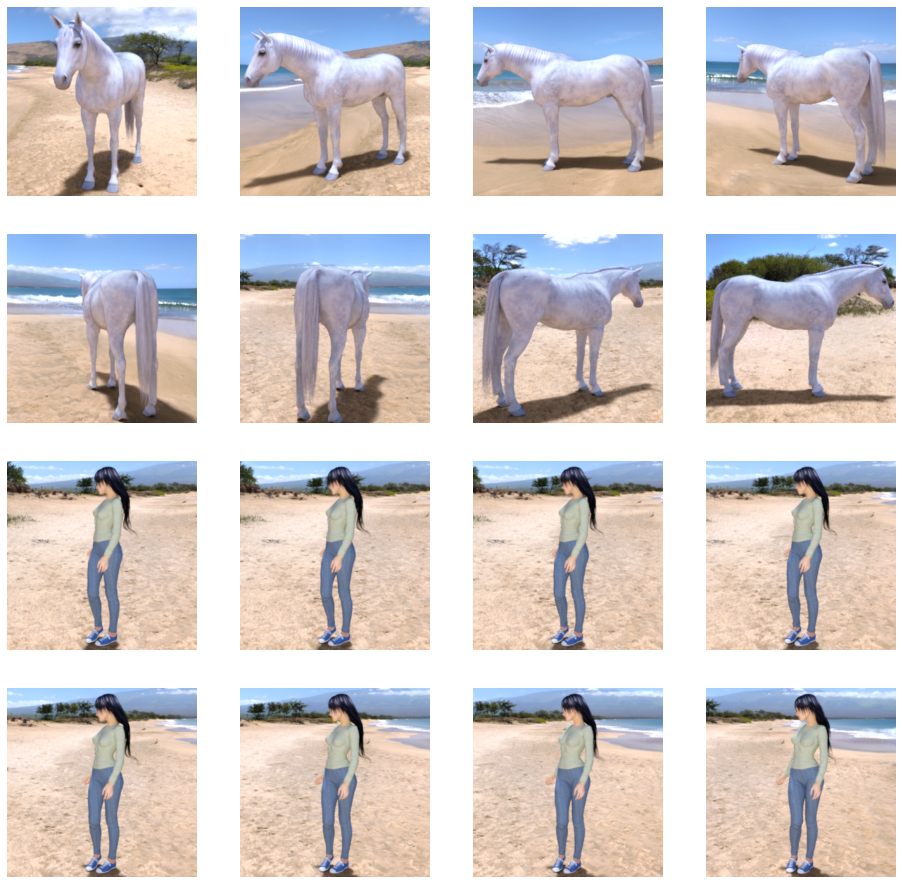

In [33]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols *4, nrows*4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname)
                    for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname)
                    for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

#### Building a Small Model from Scratch 

Now we can define the model architecture that we will train

In [34]:
import tensorflow as tf 

We then add convolutional layers and flatten the final result to feed into the densely connected layers. Since this is a two-class classification problem (_binary classification_) we will end the network with a **sigmoid activation**

This makes the output value of our network a single scalar between 0 and 1, encoding the probability that the current image is class 1

In [37]:
model = tf.keras.models.Sequential([ 
    # Note the input shape os the desired size of the image 300x300 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

We can review the network architecture and the output shapes with _model.summary()_

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

The "output shape" column shows how the size of our feature map evolves in each successive layer. The convolution layers removes the outermost pixels of the image, and each pooling layer halves the dimensions! 

Next we'll configure the specifications for model training. We'll train the model with the **binary_crossentropy** loss because it's a binary classification problem, and the final activation is a sigmoid. We will use the _RMSProp_ optimizer with a learning rate of 0.001. During training we will want to monitor classification accuracy

NOTE: _rmsprop_ automates learning-rate tuning for us

In [42]:
from tensorflow.keras.optimizers import RMSprop 

model.compile(loss='binary_crossentropy', 
                optimizer=RMSprop(learning_rate=0.001),
                metrics=['accuracy'])


#### Data Preprocessing 

Next step is to set up the data generators that will read pictures in the source folders, convert them to _float32_ tensors and feed them (with their labels) to the model. We'll have one generator for the training images and one for the validation images. These generators will yield batches of images of size 300x300 and their labels (binary)

As we may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. In this case we will preprocess the images by normalizing the pixel values to be in the [0, 1] range (originally all values are in the [0, 255] range)

In Keras this can be done via the _keras.preprocessing.image.ImageDataGenerator_ class using the rescale parameter. This ImageDataGenerator class allows us to instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory)

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    './horse-or-human/', 
    target_size = (300,300),
    batch_size=128,
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.


#### Training 

We can start training for 15 epochs

Do take note of the values per epoch 

The _loss_ and _accuracy_ are greate indicators of progress in training. _loss_ measures the current model prediction against the known labels, calculting the result. _accuracy_ is the portion of correct guesses

In [44]:
history = model.fit(
    train_generator, 
    steps_per_epoch = 8, 
    epochs=15, 
    verbose=1
)

Epoch 1/15
8/8 [==============================] - 47s 6s/step - loss: 0.8285 - accuracy: 0.5573
Epoch 2/15
8/8 [==============================] - 44s 5s/step - loss: 0.6497 - accuracy: 0.6841
Epoch 3/15
8/8 [==============================] - 49s 6s/step - loss: 0.7107 - accuracy: 0.5859
Epoch 4/15
8/8 [==============================] - 44s 5s/step - loss: 0.4630 - accuracy: 0.7820
Epoch 5/15
8/8 [==============================] - 43s 5s/step - loss: 0.7344 - accuracy: 0.7953
Epoch 6/15
8/8 [==============================] - 40s 5s/step - loss: 0.2222 - accuracy: 0.9121
Epoch 7/15
8/8 [==============================] - 39s 6s/step - loss: 0.1348 - accuracy: 0.9410
Epoch 8/15
8/8 [==============================] - 40s 5s/step - loss: 0.3530 - accuracy: 0.8654
Epoch 9/15
8/8 [==============================] - 39s 5s/step - loss: 0.1465 - accuracy: 0.9321
Epoch 10/15
8/8 [==============================] - 39s 6s/step - loss: 0.0490 - accuracy: 0.9855
Epoch 11/15
8/8 [======================

#### Model Prediction

Let's now take a look at actually making a prediction using the model. This code will allow us to choose 1 or more files from our file system, upload them and run them through the model, giving an indication of whether the object is a horse or human.

In [54]:
import numpy as np 
from tensorflow.keras.utils import load_img, img_to_array

images = os.listdir('./images')

for i in images:
    print()
    # predicting images
    path = './images/' + i
    img = load_img(path, target_size=(300,300))
    x = img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(classes[0])
    if classes[0] > 0.5:
        print(i + " is a human")
    else: 
        print(i + " is a horse")


1/1 [==============================] - 0s 34ms/step
[0.00358673]
bb.jpg is a horse

1/1 [==============================] - 0s 36ms/step
[0.18753499]
me.jpg is a horse


#### Visualizing Intermediate Representations

To get a feel for what kind of features the CNN has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the model

We can pick a random image from the training set and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. 

1/1 [==============================] - 0s 120ms/step


C:\Users\Bruger\AppData\Local\Temp\ipykernel_16720\2281274827.py:42: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


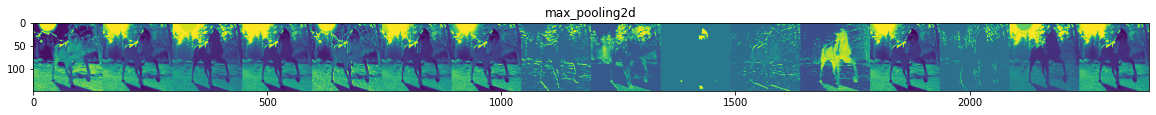

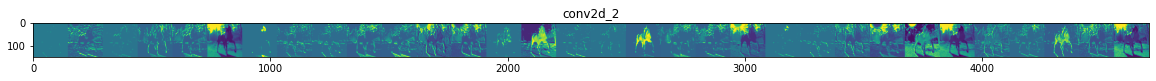

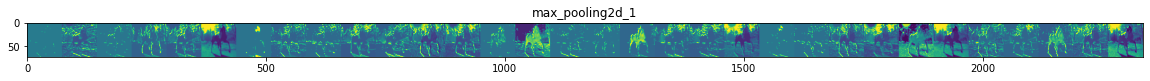

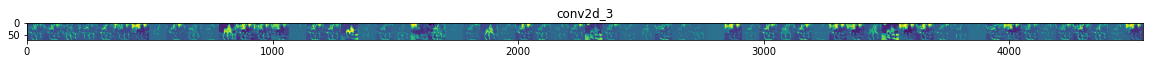

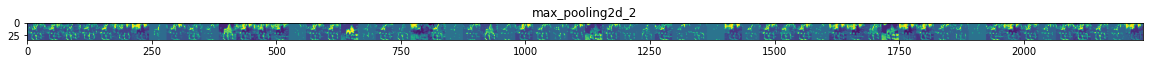

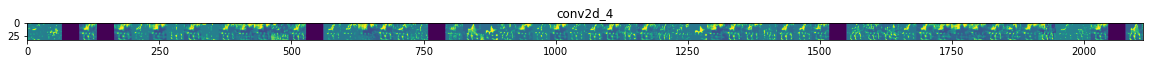

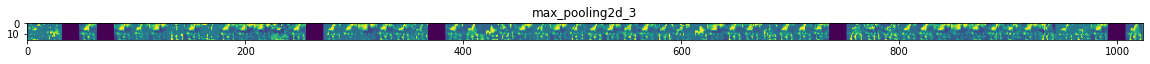

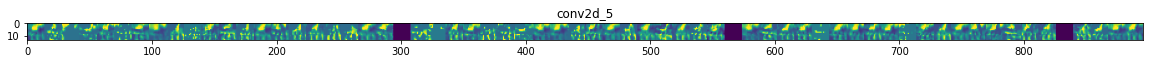

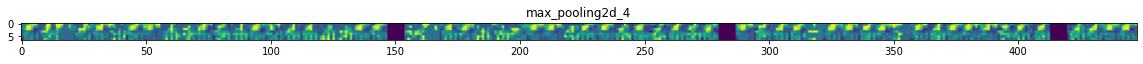

In [55]:
import random 

# Define a new Model that will take an image as input and will output intermediate representations for all layers
# in the previous model after the first

successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(300, 300))
x = img_to_array(img) # Numpy array with shape (300,300, 3)
x = x.reshape((1,) + x.shape) # Numpy array with shape (1, 300, 300, 3)

# Scale by 1/255
x /= 255

# Run the image through the network, thus obtaining all intermediate representations for this image
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers so we can have them as part of the plot
layer_names = [layer.name for layer in model.layers[1:]]

# Display the representations 
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:

        # Just do this for the conv / maxpool layers, not the fully connected layers
        n_features = feature_map.shape[-1] # number of features in feature_map

        # The feature map has shape (1, size, size, n_features)
        size = feature_map.shape[1]

        # Tile the images in this matrix
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')

            # Tile each filter into this big horizontal grid 
            display_grid[:, i * size : (i + 1) * size] = x 
        
        # Display the grid 
        scale = 20. / n_features 
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')


We can see how the pixels highlighted turn to increasingly abstract and compact representations, especially at the bottom of the grid

The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated". This is called _representation sparsity_ and is a key feature of deep learning. These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. We can think of a convnet as an information distillation pipeline wherein each layer filters out the most useful features.